In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importing necessary libraries and dependencies

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from tensorflow.keras.applications import ResNet152 , ResNet50 , VGG16 , VGG19 , EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, AveragePooling2D, Flatten, Dense, Dropout , BatchNormalization , GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imutils import paths
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import numpy as np
import pandas as pd
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array


Load Data

In [ ]:
LABELS = set([ "Actinic keratoses and intraepithelial carcinoma"  ,"Vascular lesions"  ,"Dermatofibroma" ,"Benign lesions of the keratosis","Melanoma","Normal Skin"])

Paths = [
         '/content/drive/MyDrive/myGradProject/Actinic keratoses and intraepithelial carcinoma' ,
          '/content/drive/MyDrive/myGradProject/Vascular lesions' ,
         '/content/drive/MyDrive/myGradProject/Dermatofibroma' ,
         '/content/drive/MyDrive/myGradProject/Benign lesions of the keratosis' ,
         '/content/drive/MyDrive/myGradProject/Melanoma' ,
         '/content/drive/MyDrive/myGradProject/Normal Skin'
]

In [ ]:
# Initialize empty lists to store data and labels
data = []
labels = []


for path in Paths:
    # Iterate over each image path in the directory for loading tracking
    for img_path in tqdm(paths.list_images(path)):

        # Read the image
        img = cv2.imread(img_path)

        # Convert the image color from BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize the image to a standard size (224x224)
        img = cv2.resize(img, (224, 224))

        data.append(img)
        label = img_path.split('/')[-2]
        labels.append(label)

1300it [00:34, 37.43it/s]
1200it [00:19, 60.79it/s] 
1330it [00:22, 59.94it/s] 
1200it [00:28, 42.35it/s] 
1300it [00:38, 33.81it/s]
500it [00:07, 70.34it/s] 


Display a subset of images and their labels.

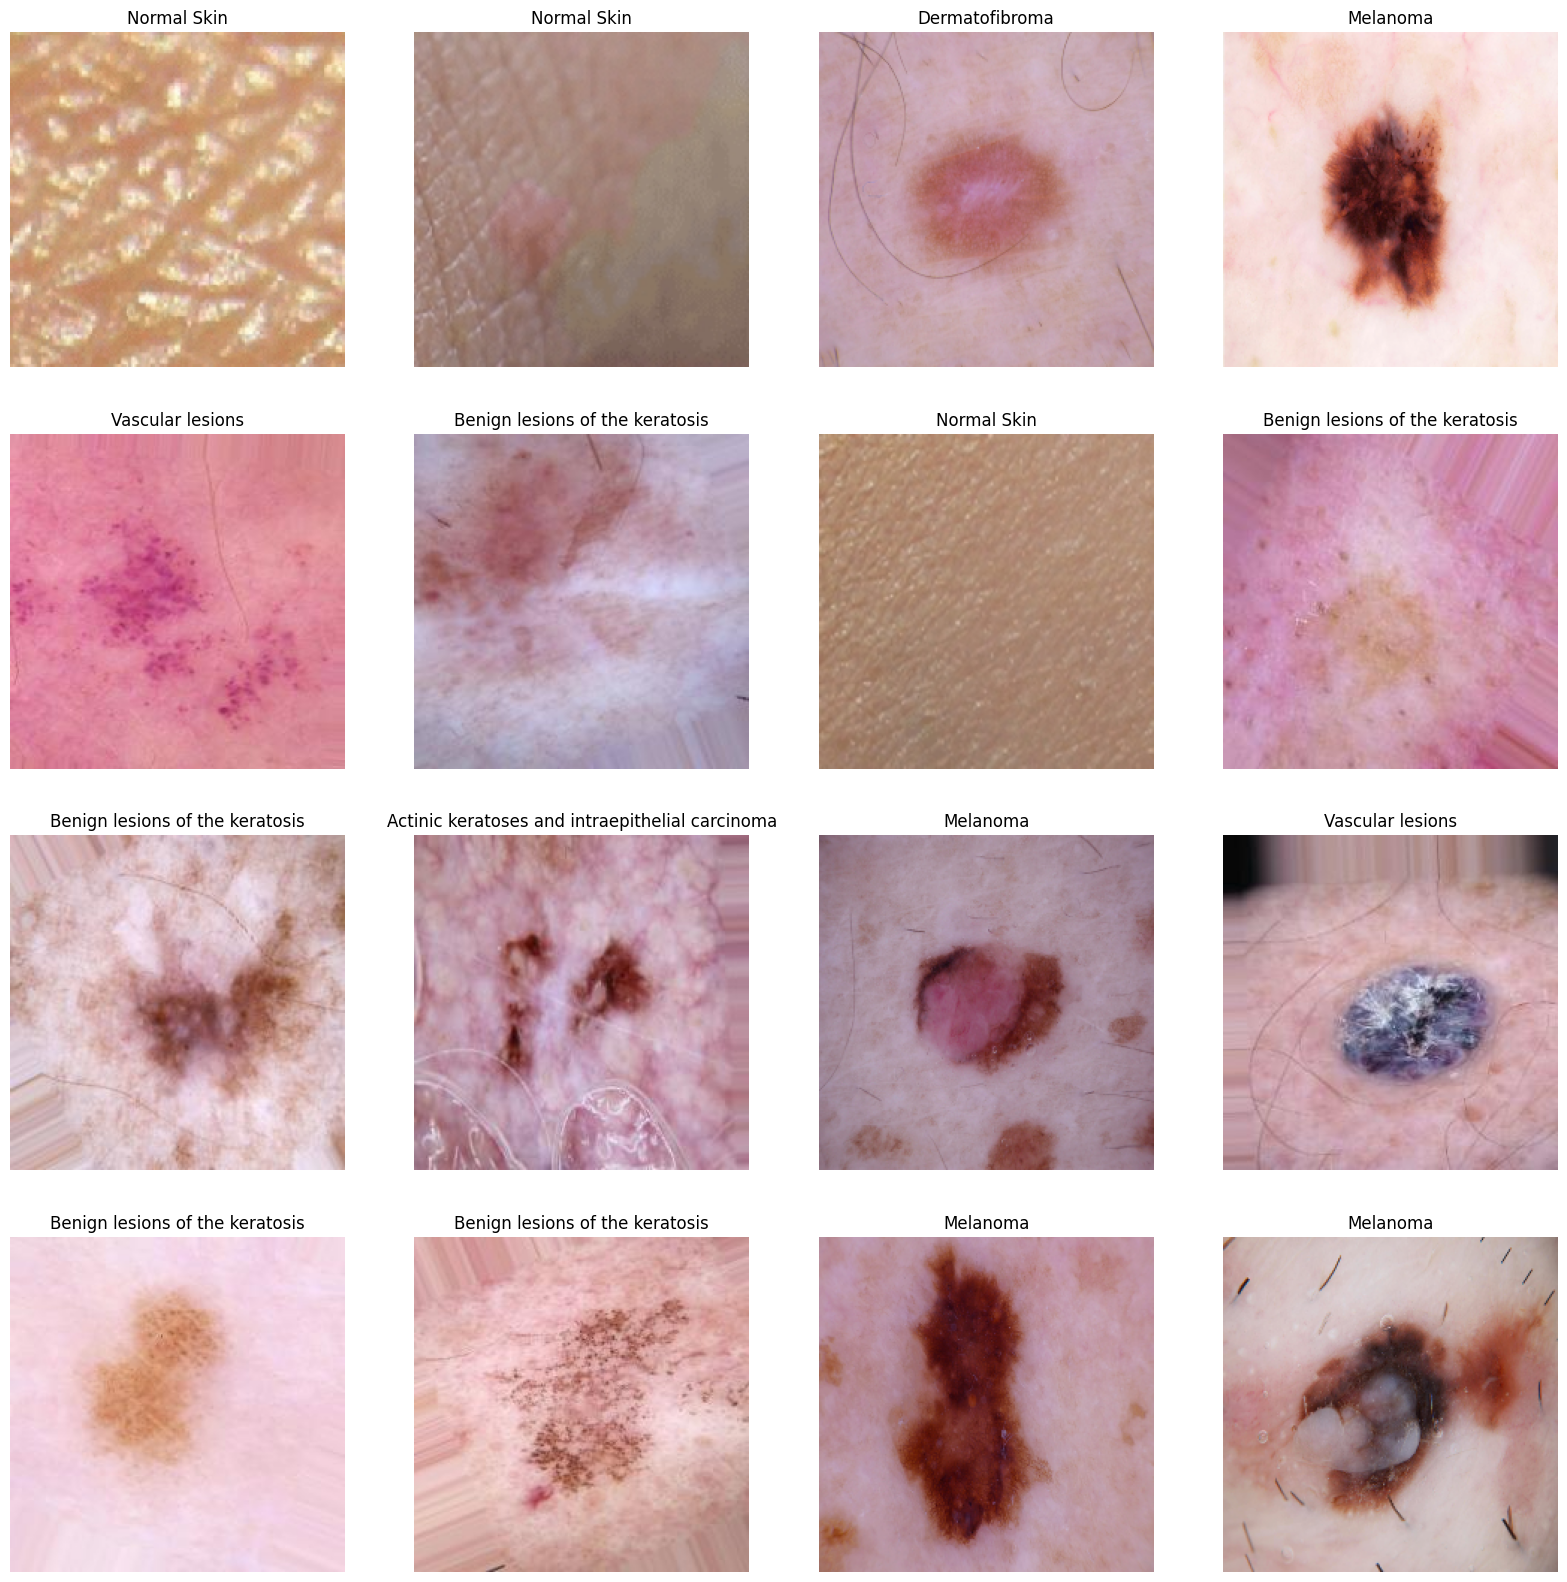

In [ ]:
# Combine data and labels into a list and shuffle them together
combined = list(zip(data, labels))
random.shuffle(combined)
data[:], labels[:] = zip(*combined)

# Define a function to display images with corresponding labels in a grid
def display_images(images, labels, rows, cols):
    # Create a figure with subplots arranged in a grid of size (rows, cols)
    fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

    for i in range(rows):
        for j in range(cols):
            index = i * cols + j
            axes[i, j].imshow(images[index])
            axes[i, j].set_title(labels[index])
            # Turn off axis ticks for better visualization
            axes[i, j].axis('off')

    plt.show()

# The number of rows and columns for the display grid
num_rows = 4
num_cols = 4

# Display the first num_rows * num_cols images and their labels
display_images(data[:num_rows * num_cols], labels[:num_rows * num_cols], num_rows, num_cols)

Building the model

In [ ]:
# ResNet50 model pre-trained
basemodel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Create the final model by adding additional layers on top of the ResNet50 base
x = basemodel.output
x = GlobalAveragePooling2D()(x)
x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)  # there are 6 classes for classification

final_model = Model(inputs=basemodel.input, outputs=x)

# Set the layers of the ResNet50 base model as non-trainable
for layer in basemodel.layers:
    layer.trainable = False

# Compile the final model
opti  = Adam(learning_rate=0.001)
final_model.compile(loss="categorical_crossentropy", optimizer=opti , metrics=["accuracy"])

# Display the summary of the final model architecture
final_model.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                         

Convert data and labels to NumPy arrays



In [ ]:
data = np.array(data)
labels = np.array(labels)


Binarizing Categorical Labels (one-hot encoding)


In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

Split the data


In [ ]:
X_train, X_cv, y_train, y_cv = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=101)

Train the model


In [ ]:
history = final_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_cv, y_cv))

Epoch 1/20
86/86 [==============================] - 37s 262ms/step - loss: 0.7781 - accuracy: 0.7279 - val_loss: 0.4412 - val_accuracy: 0.8397
Epoch 2/20
86/86 [==============================] - 20s 230ms/step - loss: 0.4106 - accuracy: 0.8519 - val_loss: 0.3415 - val_accuracy: 0.8807
Epoch 3/20
86/86 [==============================] - 20s 233ms/step - loss: 0.3052 - accuracy: 0.8949 - val_loss: 0.3137 - val_accuracy: 0.8895
Epoch 4/20
86/86 [==============================] - 19s 217ms/step - loss: 0.2516 - accuracy: 0.9114 - val_loss: 0.2372 - val_accuracy: 0.9253
Epoch 5/20
86/86 [==============================] - 20s 238ms/step - loss: 0.2029 - accuracy: 0.9286 - val_loss: 0.2329 - val_accuracy: 0.9268
Epoch 6/20
86/86 [==============================] - 21s 241ms/step - loss: 0.1851 - accuracy: 0.9341 - val_loss: 0.2266 - val_accuracy: 0.9275
Epoch 7/20
86/86 [==============================] - 21s 243ms/step - loss: 0.1375 - accuracy: 0.9513 - val_loss: 0.2081 - val_accuracy: 0.9348

Print Classification Report

In [ ]:
predictions = final_model.predict(X_cv, batch_size=64)
print(classification_report(y_cv.argmax(axis=1), predictions.argmax(axis=1), target_names=LABELS))

22/22 [==============================] - 5s 184ms/step
                                                 precision    recall  f1-score   support

                Benign lesions of the keratosis       0.90      0.91      0.91       260
                               Vascular lesions       0.98      0.93      0.95       240
                                 Dermatofibroma       0.98      0.96      0.97       266
                                       Melanoma       0.87      0.93      0.90       260
                                    Normal Skin       1.00      0.99      0.99       100
Actinic keratoses and intraepithelial carcinoma       0.98      0.97      0.97       240

                                       accuracy                           0.94      1366
                                      macro avg       0.95      0.95      0.95      1366
                                   weighted avg       0.95      0.94      0.94      1366



Visualize training and validation Accuracy

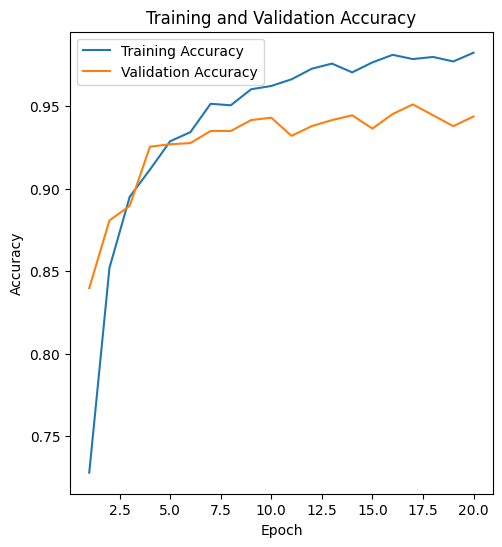

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Visualize training and validation Loss

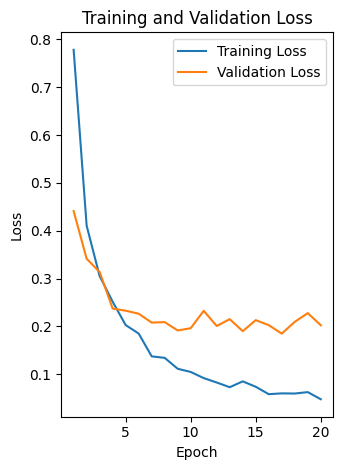

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

Save the model

In [ ]:
final_model.save("final_model.h5")